In [33]:
from glob import glob
import pandas as pd
import datetime
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Importing Data

In [34]:
# Retrieving the name of the features
features_names = list(pd.read_csv('../data/2016_01.csv', nrows=1).columns)

In [35]:
file_names = glob('../data/2016_*.csv')

# Features used from the online available air transport statistics
list_col = ['FL_DATE', 'OP_UNIQUE_CARRIER', 'CRS_DEP_TIME', 'DEST',
            'CRS_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'ORIGIN', 
            'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 
            'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', "ORIGIN_CITY_NAME", "DEST_CITY_NAME"]

col_time = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME']

# Importing data into the dataframe 'data'
data = pd.DataFrame()
for f in file_names:
    data = data.append(pd.read_csv(f, low_memory=False, usecols=list_col))
    
# Resetting the index
data = data.reset_index(drop=True)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617658 entries, 0 to 5617657
Data columns (total 16 columns):
FL_DATE                object
OP_UNIQUE_CARRIER      object
ORIGIN                 object
ORIGIN_CITY_NAME       object
DEST                   object
DEST_CITY_NAME         object
CRS_DEP_TIME           int64
CRS_ARR_TIME           int64
ARR_DELAY              float64
CANCELLED              float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
dtypes: float64(8), int64(2), object(6)
memory usage: 685.7+ MB


# Preliminary data treatment

## Processing duplicate values

In [37]:
nligne = data.shape[0]
data.drop_duplicates(inplace=True)
print("Number of duplicates : " + str(nligne - data.shape[0]))

Number of duplicates : 1


## Suppression of canceled flights

In [38]:
# removal of canceled flights
idx_cancel = data.loc[data.CANCELLED == 1].index
data = data.drop(index=idx_cancel)
data = data.drop("CANCELLED", axis=1)

## Formatting dates in the data

In [39]:
def time_format(interger):
    '''
    Formats an integer in 'string' in the format "hh: mm"
    
    examples    time_format(1255) ---> "12:55"
                time_format(745)  ---> "07:45"
                time_format(5)  ---> "00:05"
    '''
    string = str(interger)
    char_list = list(string)
    
    if string == "2400":
        tf = "00:00"
    
    elif len(string) == 4:
        liste = char_list
        tf = liste[0] + liste[1] + ":"  + liste[2] + liste[3]

    elif len(string) == 3:
        liste = ["0"] + char_list
        tf = liste[0] + liste[1] + ":"  + liste[2] + liste[3]
        
    elif len(string) == 2:
        liste = ["0", "0"] + char_list
        tf = liste[0] + liste[1] + ":"  + liste[2] + liste[3]
    
    elif len(string) == 1:
        liste = ["0", "0", "0"] + char_list
        tf = liste[0] + liste[1] + ":"  + liste[2] + liste[3]
        
    return tf

In [40]:
# Formatting of arrival and departure times
data['ARR_TIME'] = data['CRS_ARR_TIME'].apply(time_format)
data['DEP_TIME'] = data['CRS_DEP_TIME'].apply(time_format)

In [41]:
# Creation of arrival and departure date columns with schedules
data['FL_DATE_DEP'] = data.FL_DATE + " " + data.DEP_TIME
data['FL_DATE_ARR'] = data.FL_DATE + " " + data.ARR_TIME

In [42]:
# Datetime conversion
#data.loc[:, ['FL_DATE_DEP', 'FL_DATE_ARR']] = data.loc[:, ['FL_DATE_DEP', 'FL_DATE_ARR']].applymap(pd.to_datetime)
#data.loc[:, ['FL_DATE_DEP', 'FL_DATE_ARR']]  = data.loc[:, ['FL_DATE_DEP', 'FL_DATE_ARR']].astype('datetime64[ns]')
data['FL_DATE_DEP']  = data['FL_DATE_DEP'].astype('datetime64[ns]')
data['FL_DATE_ARR']  = data['FL_DATE_ARR'].astype('datetime64[ns]')

In [43]:
# Adding a day for the variable "FL_DATE_ARR" if the flight passes by midnight
date_change = data.FL_DATE_ARR.loc[data.FL_DATE_DEP > data.FL_DATE_ARR] + datetime.timedelta(days=1)
data.loc[date_change.index, "FL_DATE_ARR"] = date_change

In [44]:
# Round by the hour
data.FL_DATE_ARR = data.FL_DATE_ARR.dt.round("h")
data.FL_DATE_DEP = data.FL_DATE_DEP.dt.round("h")

In [45]:
# Remove unnecessary columns
data = data.drop(["FL_DATE", 'DEP_TIME', 'ARR_TIME'], axis=1)

## Adding variables `WEEK`, `ARR_DAY`, `DEP_DAY`, `MONTH`

In [46]:
data['ARR_DAY'] = data.FL_DATE_ARR.dt.day_name()
data['DEP_DAY'] = data.FL_DATE_DEP.dt.day_name()
data['ARR_DAY_NUM'] = data.FL_DATE_ARR.dt.dayofweek
data['DEP_DAY_NUM'] = data.FL_DATE_DEP.dt.dayofweek
data['ARR_DAY_OF_YEAR'] = data.FL_DATE_ARR.dt.dayofyear
data['DEP_DAY_OF_YEAR'] = data.FL_DATE_DEP.dt.dayofyear
data['ARR_HOUR'] = data.FL_DATE_ARR.dt.hour
data['DEP_HOUR'] = data.FL_DATE_DEP.dt.hour
data['MONTH'] = data.FL_DATE_ARR.dt.month
data['WEEK'] = data.FL_DATE_ARR.dt.week

## Consider public holidays

In [47]:
holiday = ["2016-01-01", "2016-01-18", "2016-05-30", "2016-07-04",
           "2016-09-05", "2016-11-11", "2016-11-24", "2016-12-26"]

In [48]:
for hd in holiday:
    data[hd] = pd.to_datetime(hd)
    data[hd] = np.abs((data.FL_DATE_ARR - data[hd]).dt.days)

In [49]:
data["days2holdays"] = data[holiday].min(axis=1)
data = data.drop(holiday, axis=1)

## Adding the variable `holidays`

In [50]:
df_date = pd.DataFrame(index=data.FL_DATE_DEP)
df_date["holidays"] = np.nan

In [51]:
nom_vacs = ["winter", "easter", "spring", "summer", "christmas"]
date_vacs = [("2016-02-15","2016-02-19"), ("2016-03-25","2016-04-08"), 
             ("2016-05-30","2016-06-03"), ("2016-06-20","2016-08-31"), 
             ("2016-06-20","2016-08-31")]
dict_vac = dict(zip(nom_vacs, date_vacs))
pickle.dump(dict_vac, open("../data/dict_vac.pkl", "wb"))

In [52]:
for vac, date in dict_vac.items():
    df_date.loc[date[0]:date[1]] = vac
df_date = df_date.fillna("normal")

In [53]:
df_date.index = data.index

In [54]:
data = pd.concat([data, df_date], axis=1)

## Process missing values

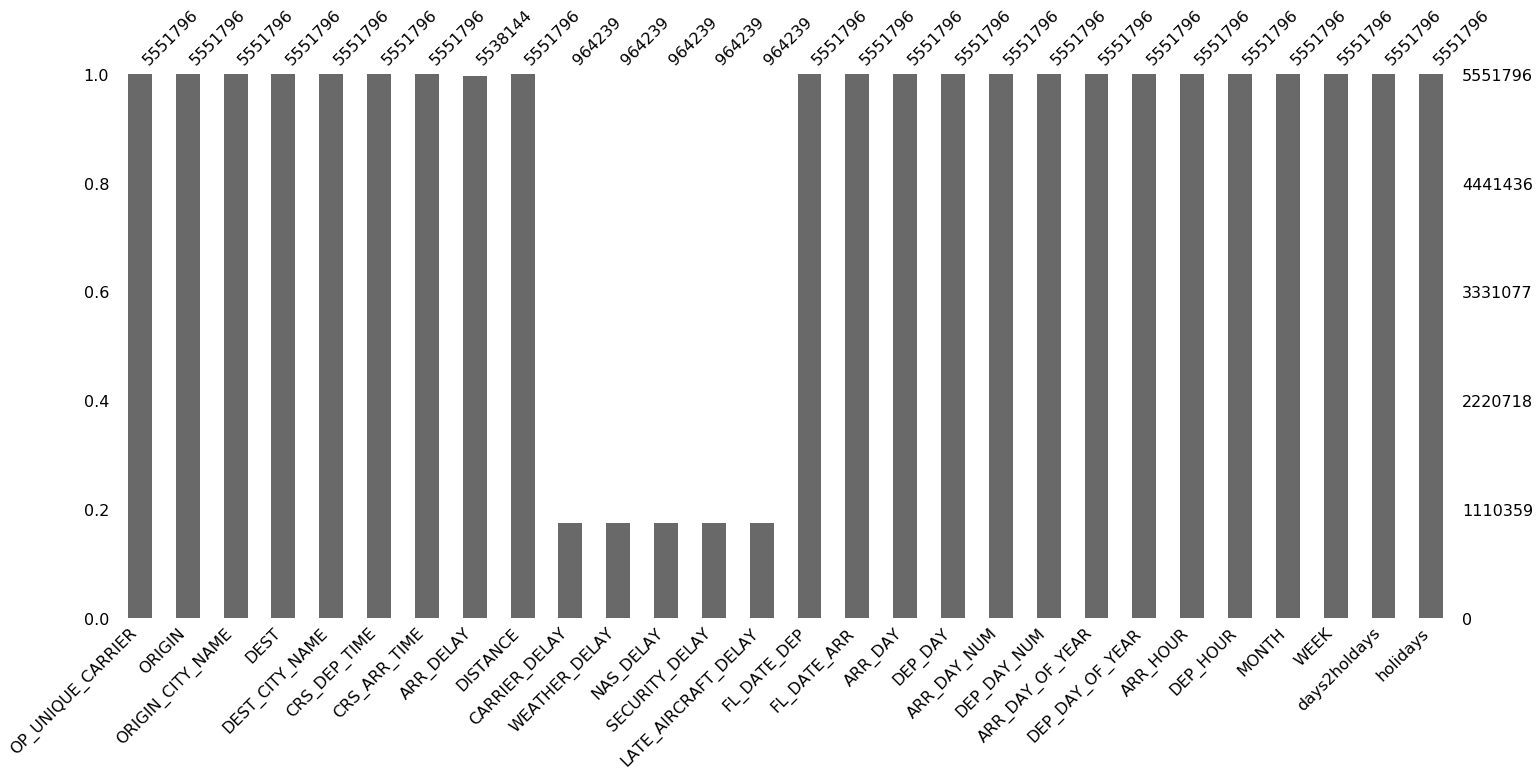

In [55]:
import missingno as msno
msno.bar(data)

In [56]:
# Suppressing default values
index_na = data.loc[data.ARR_DELAY.isna()].index
data = data.drop(index=index_na)

In [57]:
data.columns = data.columns.str.lower()
data = data.set_index("fl_date_arr")

In [58]:
data_no_na = data.dropna(how="any")

# Safeguarding data

In [59]:
# Saving names of airports and cities for API
city_airport = data.loc[:, ["origin", "origin_city_name"]]
city_airport = city_airport.drop_duplicates()
city_airport.to_csv("../data/city_airport.csv")

In [60]:
# Dataframe with missing values
data.to_csv("../data/data_clean.csv")

# Dataframe without missing values
data_no_na.to_csv("../data/data_no_na.csv")